In [1]:
from MainFiles.GP import *
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as tdb
from Windowing import *

# Introduction
First check if we can do batches of distribution then we optimize the whole thing

In [26]:
ts = torch.tensor([16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1448, 2048])

params = torch.tensor([[0.5, 0.5],[0.5,0.5],[0.01,0.01]])
means = torch.full((2,1),0.5)
cov = cov_kernel(ts,ts[...,None], params)
dist = tdb.multivariate_normal.MultivariateNormal(means,cov)

# Method
Indeed we can, nice! Now we need to optimize the whole thing

In [14]:
win = Windowing(aggCurves)
win.set_points([16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1448, 2048, 2896])

,Count
size_train,
16,245
23,246
32,246
40,1
45,244
...,...
1048576,2
1482910,1
1486391,1


In [107]:
def optimize_params(params, y, X, lr = 0.01, n_iter=100):
        params = params.clone().requires_grad_(True)
        nan = torch.isnan(y)
        nanT = nan.transpose(-1,-2)
        nan_ind = torch.where(nanT)
        y = torch.where(nan, torch.tensor(0.0), y)

        # make separate optimizers
        optimizer = torch.optim.Adam([params], lr=lr)
        gr = torch.ones(params.shape[1:])

        losses = []
        for i in range(n_iter):
            optimizer.zero_grad()
            means = params[0].repeat(15,1,1,1).permute(1,2,3,0)
            cov = cov_kernel(X,X[...,None],params[1:])
            cov[nanT,:] = 0
            cov.transpose(-1,-2)[nanT,:] = 0
            cov[nan_ind[0],nan_ind[1],nan_ind[2],nan_ind[3],nan_ind[3]] = 1 # set diagonal to 1
            N = tdb.MultivariateNormal(means,cov)
            loss = -N.log_prob(y)
            losses.append(loss.mean().item())
            if i % 10 == 0:
                print(f"Iteration {i} loss mean: {loss.mean().item()}")
            loss.backward(gradient=gr)
            optimizer.step()

            # stop loop if last 10 losses are the same rounded to 3 decimals
            if len(losses) > 10:
                if np.mean(losses[-10:]) == losses[-1]:
                    print("Stopped at iteration: ",i)
                    break

        return params, losses

In [108]:
y = torch.tensor(win.data, dtype=torch.float32)
X = torch.tensor(win.train_anchors, dtype=torch.float32)

params = torch.tensor([0.5,0.5,0.5, 0.01], dtype=torch.float32)
shp = np.hstack((np.array(y.shape[:2]), np.array(y.shape[3])))
params = params.repeat(*shp, 1)

# params at front
params = params.permute(*np.roll(np.arange(len(params.shape)),1))

params, losses = optimize_params(params, y, X, lr = 0.01, n_iter=100)

Iteration 0 loss mean: 462.3446350097656
Iteration 10 loss mean: 20.846223831176758


KeyboardInterrupt: 

# Test

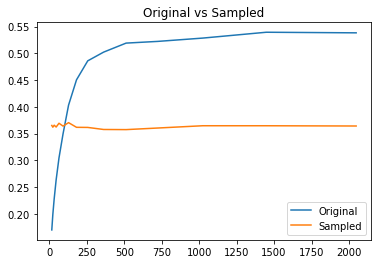

In [71]:
# For specific curve
curve = win.data[1,0,:,-1]

# Now lets compare
plt.plot(X,curve, label="Original")

# We sample 1000 times and take the mean
means = params[0,1,0,-1].repeat(X.shape[0])
cov = cov_kernel(X,X[...,None],params[1:,1,0,-1])

S = tdb.MultivariateNormal(means,cov).sample(sample_shape=torch.Size([1000])).mean(0)
plt.plot(X,S, label="Sampled")

plt.title("Original vs Sampled")
plt.legend()

In [73]:
params[:,1,0,-1]

tensor([0.3623, 0.3620, 0.6148, 0.0950], grad_fn=<SelectBackward0>)

In [ ]:
# repeat 15 times into last dimension
params[0].repeat(15,1,1,1).permute(1,2,3,0).shape